# Install And Import...

#** PIP INSTALL block**

Installing all required libraries.

In [2]:
!pip install fuzzywuzzy
!pip install python-Levenshtein
!pip install sympy
!pip install fpdf
!pip install statsmodels
!pip install pingouin
!pip install scikit-posthocs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 42.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=1dee0fa90e15d85a6896ff0c194d2fad028b466e66ae1bc538cfb139a10873a5
  Stored in directory: /root/.cache/pip/wheels/f9/95/ba/f418094659025eb9611f17cbcaf2334236bf39a0c3453ea455
Successfully built fpdf
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 4.5 MB/s eta 0:00:00


#Import block

Importing all required libraries.

In [104]:
import gspread
from google.colab import auth
from google.auth import default
from google.colab import drive
from google.colab import drive

from fuzzywuzzy import process, fuzz

import re
import subprocess
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pingouin as pg
import shutil
import torch
from fpdf import FPDF
from ast import keyword

import statistics

import scipy.stats as stats
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
from scipy.stats import levene
from scipy.stats import kruskal
from scipy.stats import spearmanr
from scipy.stats import kstest

import scikit_posthocs as sp

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# Authorizing Google User & Mounting Google Drive Authorizing GoogleSpreed

In [105]:
auth.authenticate_user()
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 to import data from Questionnaire response

In [106]:
creds, _ = default()
gs = gspread.authorize(creds)

# Storing the whole sheet in "worksheetPrime"

In [182]:
worksheetPrime = gs.open('Questionnaire 1  (Responses)').sheet1

# Defining Functions requied for Cleaning

Spelling Corrections

In [183]:
#Function to replace similar names with the most frequent one
def correct_spelling_fuzzy(df, freq_dist, similarity_threshold=85):
    # Create a copy of the DataFrame to avoid modifying the original
    corrected_colleges = df['College Name '].copy()

    # List to store which names are already corrected
    corrected = {}

    # Iterate over unique college names in the frequency table
    for college in freq_dist.index:
        if college in corrected:
            # If this college name has already been corrected, skip it
            continue

        # Find similar names using fuzzy matching
        similar_colleges = process.extract(college, freq_dist.index, scorer=fuzz.token_sort_ratio)


        # Filter names that are similar based on the threshold
        similar_colleges = [name for name, score in similar_colleges if score >= similarity_threshold]
        #print("%%%%%%%%%%%%%%%%%%")
        ##print(similar_colleges)
        #print("%%%%%%%%%%%%%%%%%%")
        # Get the most frequent similar name
        most_frequent_college = max(similar_colleges, key=lambda name: freq_dist[name])
        #print(most_frequent_college)

        # Replace all similar names with the most frequent one
        for similar in similar_colleges:
            corrected[similar] = most_frequent_college
            corrected_colleges.replace(similar, most_frequent_college, inplace=True)

    return corrected_colleges

Function to find midvalue of a Class.

In [184]:
def find_class_mid(class_interval):

    try:
        # Split the class interval string into two parts
        lower, upper = map(float, class_interval.split('-'))
        # Calculate the mid-value
        mid_value = (lower + upper) / 2
        return mid_value
    except ValueError:
        raise ValueError("Invalid class interval format. Please use the format 'start-end'.")

Cleaning 'Spending' Column

In [185]:
def process_spend(value):
    # Extract all numbers in the string
    numbers = [float(''.join(re.findall(r'\d+\.?\d*', num))) for num in re.split(r'-|\s|r', value) if any(char.isdigit() for char in num)]
    #print(numbers)
    if len(numbers) == 1:
      if numbers[0]>1000:
        return numbers[0]/100000
      else:
        return numbers[0]
    elif len(numbers) == 2:
        return sum(numbers) / 2
    else:
        return np.nan

In [186]:
def average_range(range_str):
    lower, upper = map(float, range_str.split(' - '))
    return (lower + upper) / 2

In [187]:
def has_no_numbers(input_string):
    return not bool(re.search(r'\d', input_string))

In [188]:

def clean_and_process_expected_salary(value):
    if isinstance(value, str):
        # Step 1: Standardize string and remove unnecessary characters
        value = value.lower()
        value = re.sub(r'[^\d\.\-,]', '', value)  # Remove non-numeric and non-salary relevant characters

        try:
            # Step 2: Handle ranges like '5-6 lpa' or '10-12'
            if '-' in value or 'to' in value:
                value = value.replace('to', '-')  # Normalize range indicator
                parts = [float(part) for part in re.split(r'[-]', value) if part.strip()]
                value = sum(parts) / len(parts)  # Compute average of range

            elif ',' in value:  # Step 3: Handle commas in numbers like '3,50,000'
                value = float(value.replace(',', '')) / 100000  # Normalize to lakhs

            else:  # Step 4: Convert keywords like 'lpa', 'lakhs', or per annum amounts
                if 'lpa' in value or 'lakh' in value:
                    value = float(re.sub(r'[^\d\.]', '', value))  # Extract numeric portion
                elif 'k' in value:  # Handle thousands (e.g., "50k")
                    value = float(value.replace('k', '')) / 100  # Convert to lakhs
                else:
                    value = float(value)  # Direct conversion if no keywords present

            # Step 5: Convert to lakhs if the value seems too large
            if value > 1000:
                value /= 100000  # Normalize from raw numbers like 1000000 to lakhs

            return round(value, 2)  # Round to 2 decimal places for clarity

        except ValueError:
            return None  # Invalid entries are skipped

    return None  # Return None for non-string values

Cleaning 'Parents occupation' column

* Maintaining certain order

In [189]:
def clean_occupation(occupation):
    if pd.isna(occupation) or occupation.strip() == "":
        return "Unknown"
    occupation = occupation.lower()
    if "business" in occupation or "entrepreneur" in occupation or "buisness" in occupation or "self-employed" in occupation:
        return "Business"
    elif any(keyword in occupation for keyword in ["retired","ex-serviceman","ex"]):
        return "Retired"
    elif "service" in occupation or "government" in occupation or "railway" in occupation or "sbi" in occupation or "defence" in occupation or "govt" in occupation:
        return "Government Job"
    elif "private" in occupation or "cesc" in occupation or "corporate" in occupation or "sales manager" in occupation:
        return "Private Job"
    elif "teacher" in occupation or "professor" in occupation or "teaching" in occupation or "education" in occupation:
        return "Teaching"
    elif "engineer" in occupation:
        return "Engineering"
    elif "lawyer" in occupation or "judge" in occupation or "legal" in occupation or "advocacy" in occupation:
        return "Legal Sector"
    elif any(keyword in occupation for keyword in ["doctor","health","physiotherapist"]):
        return "Health Sector"
    elif "ca" in occupation or "finance" in occupation or "accountant" in occupation:
        return "Finance"
    elif any(keyword in occupation for keyword in ["homemaker","house wife", "housewife", "home maker"]):
        return "Homemaker"
    elif any(keyword in occupation for keyword in ["tax"]):
        return "Finance"
    elif any(keyword in occupation for keyword in ["nothing", "nothing", "na", "nil", "unknown", "no idea"]):
        return "Unknown"
    else:
        return "Other"


# Data Cleaning

Differentiang Work dataset fromResponse dataset.

In [190]:
rows = worksheetPrime.get_all_values()
df = pd.DataFrame(rows).reset_index(drop=True)
df.columns = df.iloc[0]
df = df[1:].reset_index(drop=True)
df.drop(columns=['Timestamp', 'Email address','Name\n'], inplace=True)

df2=df[df['Do you consent to the use of the information provided in this form for analysis and research purposes? Your data will be handled confidentially and used solely for academic or research objectives. [ Put it on the top]'] == 'Yes, I consent'].reset_index()
df2=df2.drop("How many earning people are there in your family? ", axis=1)
df2=df2.drop("Highest Qualification of your parents", axis=1)
df2=df2.drop("Do you consent to the use of the information provided in this form for analysis and research purposes? Your data will be handled confidentially and used solely for academic or research objectives. [ Put it on the top]", axis=1)
df2=df2.drop("On a scale of 1-5 what will you rate your chosen career as a stable one. [# not required]", axis=1)

df2 = df2.rename(columns={'Do you feel financially constrained while choosing your career in higher studies? ':'Financially constrained'})
df2 = df2.rename(columns={'On scale 1-5 what do you think about the influence from your friends towards you for choosing your career path':'friend_influence','On scale 1-5 what do you think about the influence from your teacher/mentor towards you for choosing your career path':'mentor_influence','On scale 1-5 what do you think your career choice has been affected by social or cultural expectations.':'social_expectations','On a scale of 1-5 how much social media has affected your career choices in recent days.':'social_media_influence','Do you feel that Your choosen degree aligns with your personal choice':'personal_choice','On scale 1-5 what do you think about the influence from your parents towards you for choosing your career path':'parents_influence'})
df2 = df2.rename(columns={'Are you involved with any co-curricular activities? Please mention':'co-curricular activity','What was your motivation/factors behind choosing your current Stream of study?':'motivation','How much you are satisfied with your chosen Stream of study':'satisfaction','How much do you feel this degree is easy for you?':'easy','What is your preferred Working Sector?(E.g.private sector or public sector or IT sector e.t.c)':'preffed sector','Which profession you would like to pursue in future ? (e.g., data scientist , modelling, entrepreneurship) ':'profession','Your current CGPA?':'CGPA','Annual Family Income (appx)':'Family_income','How much can you invest on your in education ? (in lakhs)': 'Spending','What is your expected salary (in Lakhs Per Annum) ':'Expected_salary','By what age do you want to settle in your career?': 'Age','Subject of Specialisation [With which subject you are pursing the degree]': 'Subject', 'Percentage obtained in Class X': 'Percent_10', 'Percentage obtained in Class XII': 'Percent_12','Favourite Subject(s) till Class X and marks obtained in that subject':'fav_marks_X','Favourite Subject(s) till Class XII and marks obtained in that subject':'fav_marks_XII','College Name ':'College Name'})

In [191]:
print(df2.columns)

Index(['index', 'Age Group', 'Gender', 'College Name', 'Degree ', 'Subject',
       'Percent_10', 'co-curricular activity', 'fav_marks_X', 'Percent_12',
       'fav_marks_XII', 'motivation', 'satisfaction', 'easy', 'CGPA',
       'profession', 'preffed sector', 'Financially constrained',
       'Expected_salary', 'Age', 'Family_income', 'Parent's occupation',
       'Spending', 'parents_influence', 'friend_influence', 'mentor_influence',
       'social_expectations', 'social_media_influence', 'personal_choice'],
      dtype='object', name=0)


Cleaning 'Collage Name'

In [192]:

df2['College Name'] = df2['College Name'].str.lower().str.strip().apply(lambda x: re.sub(r'[^A-Za-z0-9 ]+', '', x))
#df2['College Name'] = correct_spelling_fuzzy(df,Refined_collegeStat)
#print(df2)
college_mapping = {
    'iem': 'institute of engineering and management',
    #'institute of engineering and management kolkata':'institute of engineering and management',
    #'iem salt lake': 'institute of engineering and management',
    #'amity university kolkata': 'amity university',
    'techno international new town': 'techno international',
    'techno international newtown':'techno international',
    'calcutta university':'university of calcutta',
    'snu': 'sister nivedita university',
    'university of engineering  management':'university of engineering and management',
    'thk jain':'Tara Devi Harakh Chand Kankaria Jain College'.lower(),
    'fiem':'Future Institute of Engineering and Management'.lower(),
    "st. xavier's college, kolkata" : "st. xavier's college",
    "st xaviers college kolkata" : "st xaviers college",
    "st xaviers autonomous kolkata" : "st xaviers college",
    'st xaviers universitykolkata':"st xaviers university",
    'techno india':'techno india university',
    'besc':'the bhawanipur educational society college',
    'the bhawanipur educational society':'the bhawanipur educational society college',
    "the bhawanipore education society":"the bhawanipur educational society college",
    'techno main salt lake':'techno india university',
    'the bhawanipur college':'the bhawanipur educational society college',
    'drsudhir chandra sur institute of technology and sports complex':'dr sudhir chandra sur institute of technology and sports complex',
    #'rkmrc':'Ramakrishna Mission Residential College'.lower(),
    'auk':'amity university'

}
df2['College Name'] = df2['College Name'].map(college_mapping).fillna(df2['College Name'])
#print(df2)
df2['College Name'] = df2['College Name'].replace(r'.*institute of engineering and management.*', 'institute of engineering and management', regex=True)
df2['College Name'] = df2['College Name'].replace(r'.*university of calcutta.*', 'university of calcutta', regex=True)
df2['College Name'] = df2['College Name'].replace(r'.*xaviers.*college.*', 'st xaviers college (autonomous)', regex=True)
df2['College Name'] = df2['College Name'].replace(r'.*xaviers university.*', 'st xaviers university', regex=True)
df2['College Name'] = df2['College Name'].replace(r'.*iem.*', 'institute of engineering and management', regex=True)
df2['College Name'] = df2['College Name'].replace(r'.*amity.*', 'amity university', regex=True)
df2['College Name'] = df2['College Name'].replace(r'.*sivanth sastri*', 'sivnath sastri college', regex=True)
df2['College Name'] = df2['College Name'].replace(r'.*west bengal national university of juridical sciences*', 'the west bengal national university of juridical sciences', regex=True)
df2['College Name'] = df2['College Name'].replace(r'.*university of engineering and management .*', 'university of engineering and management', regex=True)
df2['College Name'] = df2['College Name'].replace(r'.*rkmrc.*', 'Ramakrishna Mission Residential College'.lower(), regex=True)
df2['College Name'] = df2['College Name'].replace(r'.*presidency university.*', 'presidency university'.lower(), regex=True)
df2['College Name'] = df2['College Name'].replace(r'.*thomas college of engineering.*', 'st thomas college of engineering and technology'.lower(), regex=True)
df2['College Name'] = df2['College Name'].replace(r'.*kusum devi.*', 'Kusum Devi Sunderlal Dugar Jain Dental College'.lower(), regex=True)
df2 = df2[df2['College Name'] != 'drop out']  #drop out students are not taking under population so do in sample.

1) Assigning "Genders" : M - Male ; F - Female ; O - Others

2) Dealing With "Subjects of Specilization"


In [193]:
df2['Age'] = df2['Age'].astype(str)
df2['Gender'] = df2['Gender'].apply(lambda x: "M" if x == 'Male' else "F" if x == 'Female' else "O")

df2['Subject'] = df2['Subject'].str.lower().str.strip().apply(lambda x: re.sub(r'[^A-Za-z0-9 ]+', '', x))
df2['Subject'] = df2['Subject'].replace(r'.*statistic.*', 'Statistics'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*computer sc.*', 'computer science engineering', regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*cse.*', 'computer science engineering', regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*pharmacology.*', 'pharmacology'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*physics.*', 'Physics'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*microbiology .*', 'MicroBiology '.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*mathematics.*', 'Mathematics'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*marketing.*', 'Marketing'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*⁠life sciences.*', '⁠Life Sciences'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*aiml.*', 'Computer Science - Artificial intelligence and Machine Learning'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*data science.*', '⁠Computer Science - Data Science '.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*psychology.*', 'Psychology'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*journalism and mass communication.*', 'Journalism and Mass communication'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*information technology.*', 'Information Technology'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*laboratory technology.*', 'Medical Laboratory Technology'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*electronics and communication.*', 'Electronics and Communication'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*electrical.*', 'Electrical Engineering'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*hr.*', 'Human Resource'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*history.*', 'History'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*geography.*', 'Geography'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*fashion.*', 'Fashion Designing'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*economic.*', 'Economics'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*data visualization.*', 'Data Visualization'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*computer application.*', 'Computer Application'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*chemical.*','Chemical Engineering'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*csbs.*', 'Computer Science and Business System'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*biomedical.*', 'Biomedical Engineering'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*hospital management.*', 'Hospital Management'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*political science.*', 'Political Science'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*english.*', 'English'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*food.*', 'Food Technology'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*analytic.*', 'Analytics'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*animation.*', 'Animation'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*agricul.*','Agriculture'.lower(),regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*account.*', 'Accountancy'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*constitutional.*','Constitutional Matters'.lower(),regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*finance.*', 'Finance'.lower(),regex=True)
df2['Subject'] = df2['Subject'].replace(r'.*management.*', 'Management'.lower(), regex=True)
df2['Subject'] = df2['Subject'].replace(r'medical', np.nan)
df2['Subject'] = df2['Subject'].replace(r'engineering', np.nan)
df2['Subject'] = df2['Subject'].replace(r'na', np.nan)
df2['Subject'] = df2['Subject'].replace(r'business',  'Computer Science and Business System'.lower())
df2['Subject'] = df2['Subject'].replace(r'.*computer.*', 'computer science engineering')
df2['Subject'] = df2['Subject'].replace(r'.*instrumentation.*', 'Electronics and Instrumentation Engineering'.lower(), regex=True)
null_list = np.array(['nothing','bcom','llb','law','bachelor of business administration'])
for i in range(len(null_list)):
  df2['Subject'] = df2['Subject'].replace(null_list[i], np.nan,regex=True)


Cleaning the column 'Spending'

In [194]:
df2['Spending'] = df2['Spending'].astype(str)

df2['Spending'] = df2['Spending'].str.lower().str.strip()
df2['Spending'] = df2['Spending'].replace(r'Not a single penny more','0',regex=True)
df2['Spending'] = df2['Spending'].replace(r'.*crore.*','100',regex=True)

df2['Spending'] = df2['Spending'].apply(process_spend)

Cleaning

1) Degree

2) Expected Salary

In [195]:
df2['Degree '] = df2['Degree '].replace(r'B.Sc / BS / BCA', 'B.Sc / BS')
df2['Degree '] = df2['Degree '].str.lower().str.strip()
df2['Degree '] = df2['Degree '].replace(r'.*bfa.*','bfa',regex=True)
df2['Degree '] = df2['Degree '].replace(r'.*llb.*','llb',regex=True)
df2['Degree '] = df2['Degree '].replace(r'.*bsms.*','bsms',regex=True)
df2['Degree '] = df2['Degree '].replace(r'.*bs-ms.*','bsms',regex=True)

df2.loc[df2['Subject'].str.lower().str.strip() == 'computer application', 'Degree '] = 'bca'

In [196]:
df2['Expected_salary'] = df2['Expected_salary'].astype(str)
df2['Expected_salary'] = df2['Expected_salary'].apply(clean_and_process_expected_salary)
#print(df2['Expected_salary_mod'])

Cleaning :

1) percent 10

2) percent 12

3) Favourite Subject and Marks obtained in that subject in both 10th and 12th

*  Dealing with Class X favourite marks and it's Marks and Class XII favourite marks and it's Marks

In [197]:
df2['Percent_10'] = df2['Percent_10'].replace(r'60-70', '60 - 70')
df2['Percent_10'] = df2['Percent_10'].astype(str)
df2['Percent_10'] = df2['Percent_10'].apply(average_range)

df2['Percent_12'] = df2['Percent_12'].replace(r'60-70', '60 - 70')
df2['Percent_12'] = df2['Percent_12'].astype(str)
df2['Percent_12'] = df2['Percent_12'].apply(average_range)

In [198]:
# Extract the subject and marks from the 'fav_marks_XII' column
df2[['Favorite_Subject_10', 'Marks_10']] = df2['fav_marks_X'].str.extract(r'([A-Za-z]+)[\s:,\-(]+(\d+)')
df2[['Favorite_Subject_12', 'Marks_12']] = df2['fav_marks_XII'].str.extract(r'([A-Za-z]+)[\s:,\-(]+(\d+)')
#df2[['Favorite_Subject_12', 'Marks_12']] = df2['fav_marks_XII'].str.split('-', expand=True)

df2['Favorite_Subject_10'] = df2.apply(lambda row: row['fav_marks_X'] if has_no_numbers(row['fav_marks_X']) else row['Favorite_Subject_10'], axis=1)


# Convert 'Marks_12' to numeric, if necessary
df2['Marks_10'] = pd.to_numeric(df2['Marks_10'], errors='coerce')
df2['Marks_12'] = pd.to_numeric(df2['Marks_12'], errors='coerce')

In [199]:
df2=df2.drop('fav_marks_X', axis=1)
df2=df2.drop('fav_marks_XII', axis=1)

Subject_mapping2 = {
    'maths': 'mathematics',
    'math':'mathematics',
    'computerscience': 'computer science',
    }


df2['Favorite_Subject_10'] = df2['Favorite_Subject_10'].map(college_mapping).fillna(df2['Favorite_Subject_10'])
df2['Favorite_Subject_12'] = df2['Favorite_Subject_12'].map(college_mapping).fillna(df2['Favorite_Subject_12'])
df2 = df2.applymap(lambda x: x.lower() if isinstance(x, str) else x)

<ipython-input-199-206112aa937a>:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = df2.applymap(lambda x: x.lower() if isinstance(x, str) else x)


parents occupation

In [200]:
df2['profession'] = df2['profession'].str.lower().str.strip().apply(lambda x: re.sub(r'[^A-Za-z0-9 ]+', '', x))
df2['profession'] = df2['profession'].replace(r'.*data analyst.*', 'data analyst', regex=True)
df2['profession'] = df2['profession'].replace(r'.*msc.*','academia', regex=True)
df2['profession'] = df2['profession'].replace(r'.*sde.*','software development engineer')
df2['profession'] = df2['profession'].replace(r'.*entrepreneur.*', 'entrepreneurship', regex=True)
df2['profession'] = df2['profession'].replace(r'.*data sc.*', 'data scientist', regex=True)
df2['profession'] = df2['profession'].replace(r'.*commerce related.*', 'commercial jobs', regex=True)
df2['profession'] = df2['profession'].replace(r'.*software developer.*', 'software development engineer', regex=True)
#df2['profession'] = df2['profession'].replace(r'.*.*', '', regex=True)
df2['profession'] = df2['profession'].replace(r'.*hr.*', 'human resource', regex=True)
df2['profession'] = df2['profession'].replace(r'.*doctor.*', 'doctor', regex=True)
df2['profession'] = df2['profession'].replace(r'.*cyber.*', 'cyber security', regex=True)
df2['profession'] = df2['profession'].replace(r'.*business.*', 'entrepreneurship', regex=True)
df2['profession'] = df2['profession'].replace(r'.*administrative.*', 'administration', regex=True)
df2['profession'] = df2['profession'].replace(r'.*advoca.*', 'advocate', regex=True)
df2['profession'] = df2['profession'].replace(r'.*ai.*', 'artificial intelligence', regex=True)
df2['profession'] = df2['profession'].replace(r'.*sde.*', 'software development engineer', regex=True)
df2['profession'] = df2['profession'].replace(r'.*software eng.*', 'software development engineer', regex=True)
df2['profession'] = df2['profession'].replace(r'.*sports.*', 'sports', regex=True)
df2['profession'] = df2['profession'].replace(r'.*professor.*', 'professor', regex=True)
df2['profession'] = df2['profession'].replace(r'.*research.*', 'researcher', regex=True)
df2['profession'] = df2['profession'].replace(r'.*scientist.*', 'researcher', regex=True)
df2['profession'] = df2['profession'].replace(r'.*teach.*', 'academia', regex=True)
df2['profession'] = df2['profession'].replace(r'.*web.*', 'web developer', regex=True)
df2['profession'] = df2['profession'].replace(r'.*sports.*', 'sports', regex=True)
df2['profession'] = df2['profession'].replace(r'.*law.*', 'lawyer', regex=True)
df2['profession'] = df2['profession'].replace(r'.*advoc.*', 'lawyer', regex=True)
df2['profession'] = df2['profession'].replace(r'.*judiciary.*', 'judiciary', regex=True)
df2['profession'] = df2['profession'].replace(r'.*trading.*', 'entrepreneurship', regex=True)
df2['profession'] = df2['profession'].replace(r'.*ca.*', 'chartered accountant', regex=True)
df2['profession'] = df2['profession'].replace(r'.*ca.*', 'chartered accountant', regex=True)
df2['profession'] = df2['profession'].replace(r'.*ca.*', 'chartered accountant', regex=True)



df2['profession'] = df2['profession'].str.lower().str.strip()

df2['profession'] = df2['profession'].replace(r'.*yet.*' , 'undecided', regex=True)
df2['profession'] = df2['profession'].replace(r'.*not sure.*' , 'undecided', regex=True)
df2['profession'] = df2['profession'].replace(r'havent thought about it yet', 'undecided', regex=True)
df2['profession'] = df2['profession'].replace(r'teacher or banking job or data scientist', 'undecided', regex=True)
df2['profession'] = df2['profession'].replace(r'any statistician related role', 'undecided', regex=True)
df2['profession'] = df2['profession'].replace(r'job', 'undecided', regex=True)
df2['profession'] = df2['profession'].replace(r'ias officer or researcher', 'undecided', regex=True)
df2['profession'] = df2['profession'].replace(r'business startups or govt jobs', 'undecided', regex=True)


Reorder the columns

Cleaning

Preffed Sector

Parents' Occupation

In [201]:
# Apply the mapping to the preferred sector column
#df2['mapped_sector'] = df2[column_name].map(sector_mapping)
df2['preffed sector'] = df2['preffed sector'].replace(r'.*it.*', 'it secrtor', regex=True)
df2['preffed sector'] = df2['preffed sector'].replace(r'.*private.*', 'corporate/private sector', regex=True)
df2['preffed sector'] = df2['preffed sector'].replace(r'.*public.*', 'government/public sector', regex=True)
df2['preffed sector'] = df2['preffed sector'].replace(r'.*admin.*', 'adminstative sector', regex=True)
df2['preffed sector'] = df2['preffed sector'].replace(r'.*bio.*', 'healthcare sector', regex=True)
df2['preffed sector'] = df2['preffed sector'].replace(r'.*any.*' , 'undecided', regex=True)
df2['preffed sector'] = df2['preffed sector'].replace(r'.*banking.*', 'finance/banking sector', regex=True)
df2['preffed sector'] = df2['preffed sector'].replace(r'.*goverment.*', 'government/public sector', regex=True)
df2['preffed sector'] = df2['preffed sector'].replace(r'.*corporate.*', 'corporate/private sector', regex=True)
df2['preffed sector'] = df2['preffed sector'].replace(r'.*government.*', 'government/public sector', regex=True)
df2['preffed sector'] = df2['preffed sector'].replace(r'.*research.*', 'education sector', regex=True)
df2['preffed sector'] = df2['preffed sector'].replace(r'.*engineering.*', 'engineering sector', regex=True)
df2['preffed sector'] = df2['preffed sector'].replace(r'.*medical.*', 'healthcare sector', regex=True)
df2['preffed sector'] = df2['preffed sector'].replace(r'.*healthcare.*', 'healthcare sector', regex=True)
df2['preffed sector'] = df2['preffed sector'].replace(r'.*hospital.*', 'healthcare sector', regex=True)
df2['preffed sector'] = df2['preffed sector'].replace(r'.*education.*', 'academia/education', regex=True)
df2['preffed sector'] = df2['preffed sector'].replace(r'.*university.*', 'academia/education', regex=True)
df2['preffed sector'] = df2['preffed sector'].replace(r'.*academi.*', 'academia/education', regex=True)
df2['preffed sector'] = df2['preffed sector'].replace(r'.*sports.*', 'sports sector', regex=True)
df2['preffed sector'] = df2['preffed sector'].replace(r'.*arts.*', 'creative fields', regex=True)
df2['preffed sector'] = df2['preffed sector'].replace(r'.*content.*', 'creative fields', regex=True)
df2['preffed sector'] = df2['preffed sector'].replace(r'.*agriculture.*', 'agriculture sector', regex=True)
df2['preffed sector'] = df2['preffed sector'].replace(r'.*sales.*', 'customer care', regex=True)
df2['preffed sector'] = df2['preffed sector'].replace(r'.*watchman.*', 'others', regex=True)
df2['preffed sector'] = df2['preffed sector'].replace(r'.*home.*', 'others', regex=True)
df2['preffed sector'] = df2['preffed sector'].replace(r'.*nil.*', 'undecided', regex=True)
df2['preffed sector'] = df2['preffed sector'].replace(r'.*both.*', 'undecided', regex=True)
df2['preffed sector'] = df2['preffed sector'].replace(r'.*na.*', 'undecided', regex=True)
df2['preffed sector'] = df2['preffed sector'].replace(r'.*not.*', 'undecided', regex=True)
df2['preffed sector'] = df2['preffed sector'].replace(r'.*customer.*', 'others', regex=True)
df2['preffed sector'] = df2['preffed sector'].replace(r'.*court.*', 'judiciary', regex=True)
df2['preffed sector'] = df2['preffed sector'].replace(r'.*business.*', 'corporate/private sector', regex=True)


#df2['preffed sector'] = df2['preffed sector'].replace(r'.*.*', '', regex=True)

df2['Family_income']=df2['Family_income'].astype(str)

In [202]:
# Apply function to clean data
df2["Parent's occupation"] = df2["Parent's occupation"].apply(clean_occupation)

#print(df2['Cleaned Occupation'].to_string())

In [203]:
data = df2

def clean_age_column2(age):
  if (clean_age_column(age)) and (clean_age_column(age)>100):
    dt=[]
    dt.append(clean_age_column(age)/10)
    dt.append(clean_age_column(age)%10)
    age=statistics.mean(dt)
  else:
    return clean_age_column(age)

def clean_age_column(age):
    # Remove words and keep only numbers or ranges
    age = re.sub(r'[^\d\-]', '', str(age))
    # Handle ranges like "20-22"
    if '-' in age:
        try:
            start, end = map(int, age.split('-'))
            return (start + end) / 2  # Return average of the range
        except ValueError:
            return None

    # Handle single numbers
    elif age.isdigit():
        return int(age)
    else:
        return None

# Apply the function to the Age column
df2['Age'] = data['Age'].apply(clean_age_column2).fillna(0)

#print(data['Age'].to_string())

In [204]:
print(df2.columns)
df2['CGPA']=df2['CGPA'].astype(float)
#df2['CGPA']=df2['Age'].astype(float)
# Specify the new column order
new_column_order = ['index','Age Group', 'Gender', 'College Name', 'Degree ', 'Subject',
                    'Percent_10','Favorite_Subject_10', 'Marks_10','Percent_12','Favorite_Subject_12',
                    'Marks_12','CGPA','co-curricular activity','profession', 'preffed sector','Expected_salary','Age',
                    'Financially constrained','Family_income', "Parent's occupation",
                    'Spending', 'parents_influence', 'friend_influence', 'mentor_influence',
                    'social_expectations', 'social_media_influence', 'personal_choice']

# Reorder DataFrame columns
df2 = df2[new_column_order]

Index(['index', 'Age Group', 'Gender', 'College Name', 'Degree ', 'Subject',
       'Percent_10', 'co-curricular activity', 'Percent_12', 'motivation',
       'satisfaction', 'easy', 'CGPA', 'profession', 'preffed sector',
       'Financially constrained', 'Expected_salary', 'Age', 'Family_income',
       'Parent's occupation', 'Spending', 'parents_influence',
       'friend_influence', 'mentor_influence', 'social_expectations',
       'social_media_influence', 'personal_choice', 'Favorite_Subject_10',
       'Marks_10', 'Favorite_Subject_12', 'Marks_12'],
      dtype='object', name=0)


In [205]:
# Example: Converting a column named 'column_name' to integers
list5=['parents_influence',	'friend_influence',	'mentor_influence','social_expectations',	'social_media_influence','personal_choice']
for i in range(len(list5)):
   df2[list5[i]] = df2[list5[i]].astype(int)

<ipython-input-205-f528e27627e8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[list5[i]] = df2[list5[i]].astype(int)
<ipython-input-205-f528e27627e8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[list5[i]] = df2[list5[i]].astype(int)
<ipython-input-205-f528e27627e8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

# Dealing with outliers

Deleting Outliers with help of IQR method

In [206]:


# Copy of the original dataframe for reference
df_clean = df2.copy()

# Create a DataFrame to store eliminated data points
outliers = pd.DataFrame()

# Define a function to identify outliers based on IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

# Define a function to detect outliers in numerical ranges
def detect_outliers_range(data, column, min_value, max_value):
    return data[(data[column] < min_value) | (data[column] > max_value)]

# Define the columns and conditions for outlier detection
columns_conditions = {
    #"Age Group": {"method": "range", "min": 18, "max": 25},
    "Percent_10": {"method": "range", "min": 0, "max": 100},
    "Percent_12": {"method": "range", "min": 0, "max": 100},
    "CGPA": {"method": "range", "min": 0, "max": 10},
    "Expected_salary": {"method": "iqr"},
    #"Age": {"method": "iqr"},
    #"Family_income": {"method": "iqr"},
    "Spending": {"method": "iqr"},
}

# Process each column for outlier detection
for column, condition in columns_conditions.items():
    if condition["method"] == "range":
        outliers_detected = detect_outliers_range(df_clean, column, condition["min"], condition["max"])
    elif condition["method"] == "iqr":
        outliers_detected = detect_outliers_iqr(df_clean, column)

    # Add detected outliers to the outliers DataFrame
    outliers = pd.concat([outliers, outliers_detected])

    # Remove outliers from the clean DataFrame
    df_clean = df_clean.drop(outliers_detected.index)

# Remove duplicates from the outliers DataFrame
outliers = outliers.drop_duplicates()

# Save the cleaned data and outliers to separate files if needed
# df_clean.to_csv('cleaned_data.csv', index=False)
# outliers.to_csv('outliers_data.csv', index=False)
#print(outliers.to_string())
# Print summary
print("Number of outliers removed:", len(outliers))
print("Cleaned data size:", len(df_clean))

df2=df_clean.reset_index(drop=True)
#print(df2.to_string())


Number of outliers removed: 14
Cleaned data size: 172


# Upload Dataset to Google drive.

In [207]:
df.to_csv('/content/drive/MyDrive/pdf files/response.csv', index=False)
df2.to_csv('/content/drive/MyDrive/pdf files/refined.csv', index=False)


1) Creting Freq Dist. Table for **College Name and it's count**

2) Exporting Freq. Dist. table as PDF

In [208]:
frequency_table2 = df2[df2['College Name']!= 'college name']['College Name'].value_counts()
print(frequency_table2)
total_frequency = frequency_table2.sum()
#print(df['College Name '].unique())
cOnt=len(df2['College Name'].unique())-1
print("No. of colleges:", cOnt)
print("total:",total_frequency )

College Name
sister nivedita university                                          24
institute of engineering and management                             16
st xaviers university                                               11
jadavpur university                                                  8
techno international                                                 7
techno india university                                              7
asutosh college                                                      5
maulana azad college                                                 5
st xaviers college (autonomous)                                      5
presidency university                                                5
surendranath college                                                 5
university of calcutta                                               4
university of engineering and management                             4
amity university                                                

Creating PDf

In [209]:
pdf = FPDF()  # Create an instance of FPDF
pdf.add_page()   # Add a page
pdf.set_font("Arial", 'B', 16)  # Set the font for the PDF: (font name, style, size)
pdf.cell(200, 10, txt="Data to PDF", ln=True, align='C')  # Add a title
pdf.set_font("Arial", 'B', 12) # Add another line of text
pdf.cell(140, 10, 'College Names', border=1, align='C')
pdf.cell(50, 10, 'Frequency', border=1, ln=True, align='C')
pdf.set_font("Arial", '', 12)  # Set font for table body

# Add frequency table rows to the PDF in a well-aligned table format
for indexi, value2 in frequency_table2.items():
  safe_indexi = indexi.encode('latin-1', errors='replace').decode('latin-1')  # Replace unsupported characters
  pdf.cell(140, 10, safe_indexi, border=1)  # College name column
  pdf.cell(50, 10, str(value2), border=1, ln=True)  # Frequency column

# Add total frequency and number of unique colleges
pdf.ln(10)
pdf.set_font("Arial", 'B', 12)
pdf.cell(140, 10, 'No. of colleges:', border=1)
pdf.cell(50, 10, str(cOnt), border=1, ln=True)

pdf.cell(140, 10, 'Total frequency:', border=1)
pdf.cell(50, 10, str(total_frequency), border=1, ln=True)

output_file = 'filterColDistTable.pdf'
pdf.output(output_file)

# Correct file name for uploading
file_to_upload = output_file
target_folder = '/content/drive/MyDrive/pdf files'

shutil.copy(file_to_upload, target_folder)  # Copy the file to the shared folder

print('File uploaded to shared folder successfully!')

File uploaded to shared folder successfully!


# Modifing Dataset as per the need of Analysis

In [210]:
df3=df2
df3['Gender_code'] = df3['Gender'].apply(lambda x: 1 if x == 'm' else -1 if x == 'f' else 0)
df3['Financially constrained_coded'] = df2['Financially constrained'].apply(lambda x: 0 if x == 'no' else 1 if x == 'yes' else 2)
df3['Age_Group_code'] = df3['Age Group'].apply(find_class_mid)
df3['college_code'] = df3['College Name'].astype('category').cat.codes + 1
df3['Family_income_coded'] = df2['Family_income'].apply(
    lambda x: 0 if x == 'below 3 lakhs' else
              1 if x == '3 -  7  lakhs' else
              2 if x == '7 - 10 lakhs' else
              3 if x == '10 - 12 lakhs' else
              4 if x == '12 - 15 lakhs' else 5)




new_column_order = ['index','Age_Group_code','Age Group','Gender_code', 'Gender','college_code', 'College Name',
                    'Degree ', 'Subject','Percent_10','Favorite_Subject_10', 'Marks_10','Percent_12','Favorite_Subject_12',
                    'Marks_12','CGPA','co-curricular activity','profession', 'preffed sector','Age','Expected_salary','Financially constrained_coded',
                    'Financially constrained','Family_income_coded','Family_income', "Parent's occupation",
                    'Spending', 'parents_influence', 'friend_influence', 'mentor_influence',
                    'social_expectations', 'social_media_influence', 'personal_choice']

# Reorder DataFrame columns
df3 = df3[new_column_order]

In [211]:
df3.to_csv('/content/drive/MyDrive/pdf files/refined_ForWork.csv', index=False)

# Analysis

Simple and Multiple Correlation

In [212]:
def multiple_correlation(cgpa, percent_10, percent_12):
    # Calculate pairwise correlation coefficients
    r_Y_X1 = np.corrcoef(cgpa, percent_10)[0, 1]
    r_Y_X2 = np.corrcoef(cgpa, percent_12)[0, 1]
    r_X1_X2 = np.corrcoef(percent_10, percent_12)[0, 1]

    # Calculate multiple correlation coefficient
    numerator = (r_Y_X1**2 + r_Y_X2**2 - 2 * r_Y_X1 * r_Y_X2 * r_X1_X2)
    denominator = (1 - r_X1_X2**2)
    R_Y_X1X2 = np.sqrt(numerator / denominator) if denominator != 0 else np.nan  # To handle division by zero

    return R_Y_X1X2

In [213]:
correlation = df3['Spending'].corr(df3['Family_income_coded'])
print("Correlation b/w Family income and Amnt students are ready to invest in Higher Education:", correlation)

correlation2 = df3['Percent_10'].corr(df3['Percent_12'])
print("Correlation b/w Class 10 Avg. & Class 12 Avg.:", correlation2)

correlation3 = df3['Spending'].corr(df3['college_code'])
print("Correlation b/w Spending & Colleges :", correlation3)

Correlation b/w Family income and Amnt students are ready to invest in Higher Education: 0.3306474382627555
Correlation b/w Class 10 Avg. & Class 12 Avg.: 0.47485554391991824
Correlation b/w Spending & Colleges : -0.035226311165269975


In [214]:
#print(type(df2['CGPA']))
df3['CGPA'] = pd.to_numeric(df2['CGPA'], errors='coerce')
df3['Percent_10'] = pd.to_numeric(df2['Percent_10'], errors='coerce')
df3['Percent_12'] = pd.to_numeric(df2['Percent_12'], errors='coerce')


multiple_corr = multiple_correlation(df3['CGPA'], df3['Percent_10'], df3['Percent_12'])
print("Multiple Correlation (CGPA with Percent_10 and Percent_12):", multiple_corr)

Multiple Correlation (CGPA with Percent_10 and Percent_12): 0.3258946610261223


# Analysis 2  Part 1

#Regression

In [215]:
# Define the independent variables (X) and the dependent variable (y)
X = df3[['Percent_10', 'Percent_12']]
y = df3['CGPA']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the model
model_stats1 = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model_stats1.summary())

                            OLS Regression Results                            
Dep. Variable:                   CGPA   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     10.04
Date:                Fri, 03 Jan 2025   Prob (F-statistic):           7.58e-05
Time:                        18:20:11   Log-Likelihood:                -392.57
No. Observations:                 172   AIC:                             791.1
Df Residuals:                     169   BIC:                             800.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0520      1.986     -0.530      0.5

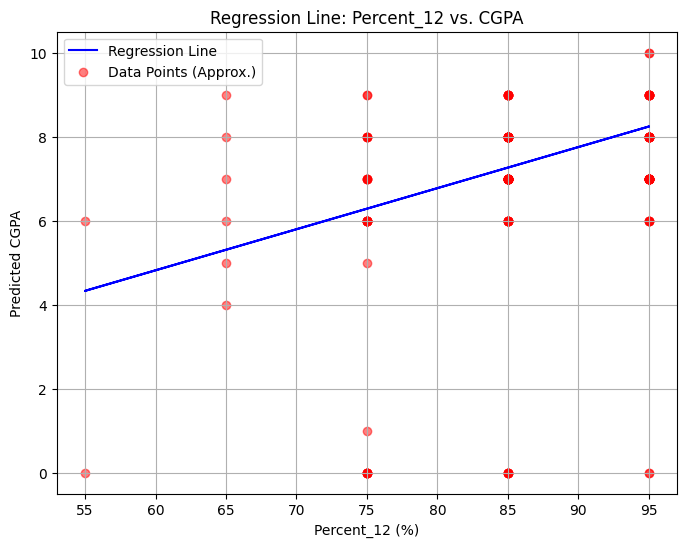

In [216]:
const = -1.0520
percent_12_coef = 0.0978

# Generate sample Percent_12 values (Assuming range from 60% to 100%)
percent_12_values = df3['Percent_12']

# Calculate corresponding CGPA using the regression equation
cgpa_values = const + percent_12_coef * percent_12_values

# Plot the regression line
plt.figure(figsize=(8, 6))
plt.plot(percent_12_values, cgpa_values, color='blue', label='Regression Line')
plt.scatter(percent_12_values, df3['CGPA'], color='red', alpha=0.5, label='Data Points (Approx.)')
plt.title('Regression Line: Percent_12 vs. CGPA')
plt.xlabel('Percent_12 (%)')
plt.ylabel('Predicted CGPA')
plt.legend()
plt.grid(True)
plt.show()

Performing VIF tet as the above Regression shows High Value of Condition Number. to find Multicoliniarity on numarical Columns.

In [217]:
selected_columns = ['Age_Group_code','Gender_code', 'college_code', 'Percent_10','Marks_10','Percent_12','Marks_12','CGPA','Expected_salary','Spending','parents_influence',	'friend_influence',	'mentor_influence','social_expectations',	'social_media_influence','personal_choice']  # Replace with your desired columns
for i in range(len(selected_columns)):
  #print(type(df3[selected_columns[i]][1]))
  # Replace NaN values in 'column_name' with 0
  df3[selected_columns[i]] = df3[selected_columns[i]].fillna(0)
print(type(selected_columns))
df3_selected = df3[selected_columns]

<class 'list'>


In [218]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = df3_selected.columns

# Calculating VIF for each feature
vif_data["VIF"] = [
    variance_inflation_factor(df3_selected.values, i)
    for i in range(len(df3_selected.columns))
]

print(vif_data)

                   feature         VIF
0           Age_Group_code   95.981894
1              Gender_code    1.163013
2             college_code    6.123583
3               Percent_10  127.016427
4                 Marks_10   40.645432
5               Percent_12  154.899307
6                 Marks_12   39.961935
7                     CGPA    9.566760
8          Expected_salary    3.365143
9                 Spending    2.341092
10       parents_influence    8.771882
11        friend_influence    5.782541
12        mentor_influence    7.670473
13     social_expectations    6.210238
14  social_media_influence    5.774449
15         personal_choice   12.005765


Principle Component Analysis

In [219]:
df_new = df3[['Marks_10','Marks_12','Percent_10','Percent_12']]
print(df_new)

0    Marks_10  Marks_12  Percent_10  Percent_12
0        94.0      97.0        85.0        95.0
1        99.0      99.0        95.0        95.0
2         0.0       0.0        95.0        95.0
3        89.0      80.0        85.0        85.0
4        70.0      77.0        75.0        75.0
..        ...       ...         ...         ...
167      95.0      90.0        95.0        85.0
168      85.0      70.0        85.0        75.0
169      85.0      91.0        85.0        85.0
170      95.0      85.0        85.0        85.0
171      96.0      86.0        95.0        95.0

[172 rows x 4 columns]


In [220]:
def perform_pca(data, n_components=None):
    """
    Performs PCA on the given dataset and returns explained variance ratios,
    transformed components, and the PCA model.

    Args:
        data (pd.DataFrame): The input dataset (numerical columns only).
        n_components (int or None): Number of principal components to keep.
                                    If None, keep all components.

    Returns:
        tuple: (explained variance ratios, transformed components, PCA model)
    """
    # Standardize the data (important for PCA)
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Perform PCA
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(data_scaled)

    # Explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_

    return explained_variance_ratio, principal_components, pca



Explained Variance Ratio: [0.53549729 0.27145046]
Principal Components:
 [[ 9.48349081e-01  4.12110219e-02]
 [ 1.53661744e+00  5.52952564e-01]
 [-3.15054898e+00  4.16692612e+00]
 [-8.30569547e-02 -7.26664029e-02]
 [-1.55461295e+00 -9.06950442e-01]
 [ 1.43818499e-01 -3.00493385e-01]
 [-2.49440753e-01 -9.32366594e-01]
 [-2.56092468e+00 -4.70618444e-01]
 [-1.38413297e-02 -1.15186102e-01]
 [ 7.56154299e-01  1.74286422e-01]
 [-4.15543544e-01 -7.85890510e-01]
 [ 2.93099895e-02 -1.15533748e+00]
 [-6.48810903e+00  6.04797014e-02]
 [-5.41954407e-01 -7.52169093e-01]
 [ 8.30689873e-01  1.35708914e-01]
 [ 5.61640704e-02 -1.95124486e-01]
 [ 4.75206621e-01  4.28204131e-01]
 [ 5.19425893e-02 -2.14540085e-01]
 [-1.57283836e-01 -1.21436182e-02]
 [ 9.21467315e-01  6.52290233e-02]
 [-1.38845032e-01 -7.49928185e-02]
 [ 1.44052005e+00  6.19490264e-01]
 [ 2.43038903e-01 -3.32142076e-01]
 [-1.94365072e+00 -1.51940805e+00]
 [-6.43798473e-01 -1.54876639e+00]
 [ 8.82256470e-01  1.18619730e-01]
 [-8.62085246e-01

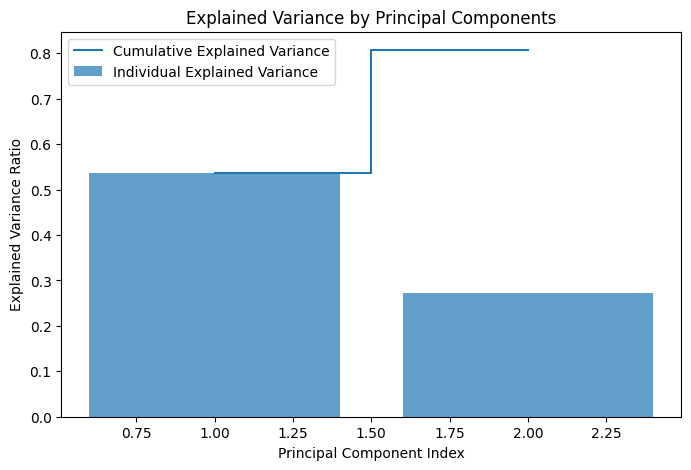

In [221]:
n_components = 2  # Specify the number of components
explained_variance, components, pca_model = perform_pca(df_new, 2)
df3 = pd.concat([df3, pd.DataFrame(components, columns=['Marks1', 'Marks2'])], axis=1)
df3 = df3.drop(['Marks_10','Marks_12','Percent_10','Percent_12'], axis=1)

print("Explained Variance Ratio:", explained_variance)
print("Principal Components:\n", components)
print(type(components))
# Plot the explained variance
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center', label='Individual Explained Variance')
plt.step(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), where='mid', label='Cumulative Explained Variance')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.legend(loc='best')
plt.show()

Correlation Matrix

In [222]:
def cramers_v(chi2, n, rows, cols):
    return np.sqrt(chi2 / (n * (min(rows-1, cols-1))))

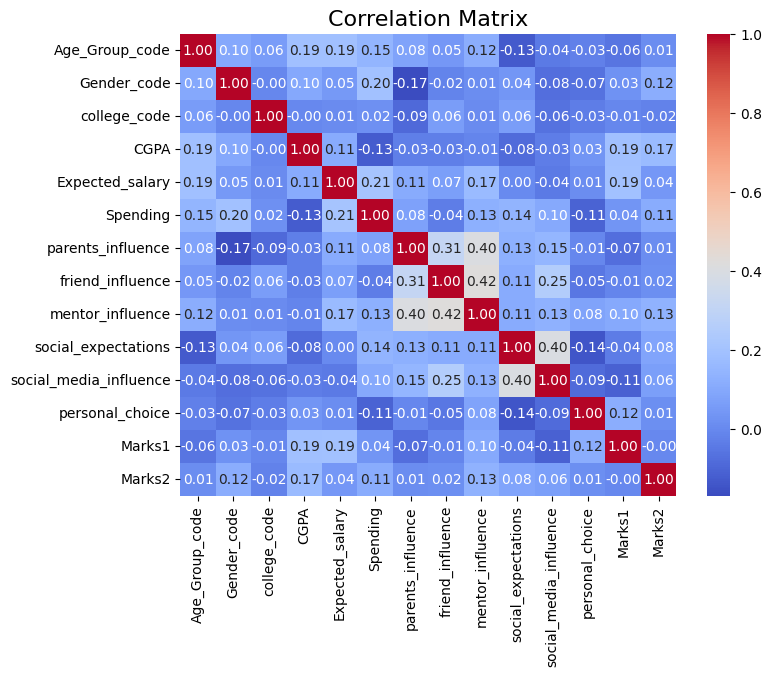

In [223]:
def plot_correlation_matrix(data, columns):
    # Compute the correlation matrix for the specified columns
    correlation_matrix = data[columns].corr()

    # Set up the figure and axis
    plt.figure(figsize=(8, 6))

    # Plot the heatmap
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)

    # Add title
    plt.title("Correlation Matrix", fontsize=16)

    # Show the plot
    plt.show()

selected_columns.append('Marks1')
selected_columns.append('Marks2')
selected_columns.remove('Marks_10')
selected_columns.remove('Marks_12')
selected_columns.remove('Percent_10')
selected_columns.remove('Percent_12')
plot_correlation_matrix(df3, selected_columns)

# Analysis 1

Performing Chi-square test for Indepence b/w 'Profession' and 'parents_influence'

In [224]:
# Create a contingency table
contingency_table = pd.crosstab(df3['preffed sector'], df3["Parent's occupation"])

# Perform Chi-Square Test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Results
#print("Contingency Table:\n", contingency_table)
print("Chi-Square Statistic:", chi2)
print("p-value:", p)
print("Degrees of Freedom:", dof)
#print("Expected Frequencies:\n", expected)

# Interpretation
alpha = 0.05
if p <= alpha:
    print("Reject the null hypothesis: Degree and parents_influence are dependent.")
else:
    print("Fail to reject the null hypothesis: profession chosen and parent's occupation are independent.")

# Assuming you have the Chi-Square test results
n = contingency_table.sum().sum()
rows, cols = contingency_table.shape
v = cramers_v(chi2, n, rows, cols)
print("Cramér's V:", v)

Chi-Square Statistic: 294.44808055091744
p-value: 1.509226451075096e-12
Degrees of Freedom: 143
Reject the null hypothesis: Degree and parents_influence are dependent.
Cramér's V: 0.394497084338053


In [225]:
# Create a contingency table
contingency_table = pd.crosstab(df3['social_media_influence'], df3["Degree "])

# Perform Chi-Square Test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Results
#print("Contingency Table:\n", contingency_table)
print("Chi-Square Statistic:", chi2)
print("p-value:", p)
print("Degrees of Freedom:", dof)
#print("Expected Frequencies:\n", expected)

# Interpretation
alpha = 0.05
if p <= alpha:
    print("Reject the null hypothesis: Degree and parents_influence are dependent.")
else:
    print("Fail to reject the null hypothesis: profession chosen and parent's occupation are independent.")

Chi-Square Statistic: 72.73305147106714
p-value: 0.12529427949801725
Degrees of Freedom: 60
Fail to reject the null hypothesis: profession chosen and parent's occupation are independent.


In [226]:
# Create a contingency table
contingency_table = pd.crosstab(df3['profession'], df3["Parent's occupation"])

# Perform Chi-Square Test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Results
#print("Contingency Table:\n", contingency_table)
print("Chi-Square Statistic:", chi2)
print("p-value:", p)
print("Degrees of Freedom:", dof)
#print("Expected Frequencies:\n", expected)

# Interpretation
alpha = 0.05
if p <= alpha:
    print("Reject the null hypothesis: Degree and parents_influence are dependent.")
else:
    print("Fail to reject the null hypothesis: profession chosen and parent's occupation are independent.")

Chi-Square Statistic: 673.7209537301455
p-value: 0.09566478197699446
Degrees of Freedom: 627
Fail to reject the null hypothesis: profession chosen and parent's occupation are independent.


Performing Chi-square test for Indepence b/w 'Degree' and 'parents_influence'

In [227]:
# Create a contingency table
contingency_table = pd.crosstab(df3['Degree '], df3['parents_influence'])

# Perform Chi-Square Test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Results
#print("Contingency Table:\n", contingency_table)
print("Chi-Square Statistic:", chi2)
print("p-value:", p)
print("Degrees of Freedom:", dof)
#print("Expected Frequencies:\n", expected)

# Interpretation
alpha = 0.05
if p <= alpha:
    print("Reject the null hypothesis: Degree and parents_influence are dependent.")
else:
    print("Fail to reject the null hypothesis: Degree and parents_influence are independent.")

Chi-Square Statistic: 51.26540747974704
p-value: 0.781724470003274
Degrees of Freedom: 60
Fail to reject the null hypothesis: Degree and parents_influence are independent.


Performing Chi-square test for Indepence b/w 'Gender' and 'Profrssion'

In [228]:
data = df3

# Create a contingency table for Gender and Profession
contingency_table = pd.crosstab(data['Gender'], data['profession'])

# Perform the Chi-Square Test of Independence
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Display the results
#print("Contingency Table:")
#print(contingency_table)
print("\nChi-Square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
#print("\nExpected Frequencies:")
#print(expected)
alpha = 0.05
if p < alpha:
  print("The test shows a significant relationship (reject the null hypothesis).")
else:
  print("The test does not show a significant relationship (fail to reject the null hypothesis).")




Chi-Square Statistic: 96.93067990832697
P-value: 0.8744382163511979
Degrees of Freedom: 114
The test does not show a significant relationship (fail to reject the null hypothesis).


Performing Chi-square test for Indepence b/w 'Degree' and 'Expected Salary'

In [229]:
# Create a contingency table
contingency_table = pd.crosstab(df3['Degree '], df3['Expected_salary'])

# Perform Chi-Square Test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Results
#print("Contingency Table:\n", contingency_table)
print("Chi-Square Statistic:", chi2)
print("p-value:", p)
print("Degrees of Freedom:", dof)
#print("Expected Frequencies:\n", expected)

# Interpretation
alpha = 0.05
if p <= alpha:
    print("Reject the null hypothesis: Degree and parents_influence are dependent.")
else:
    print("Fail to reject the null hypothesis: Degree and parents_influence are independent.")

Chi-Square Statistic: 1074.9618349521543
p-value: 8.180748405044271e-21
Degrees of Freedom: 675
Reject the null hypothesis: Degree and parents_influence are dependent.


Checking for strength of association b/w variables.

In [230]:
# Assuming you have the Chi-Square test results
n = contingency_table.sum().sum()
rows, cols = contingency_table.shape
v = cramers_v(chi2, n, rows, cols)
print("Cramér's V:", v)

Cramér's V: 0.645485765925526


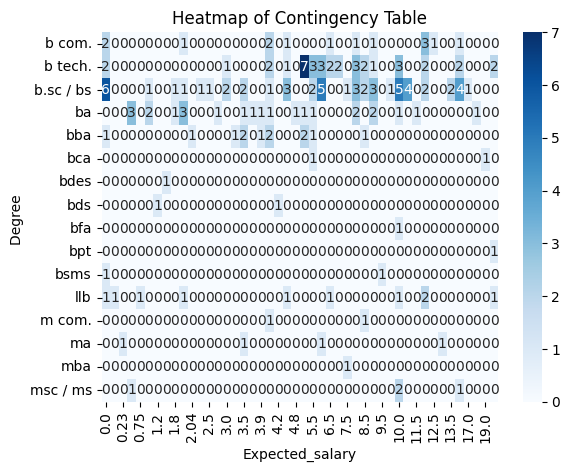

In [231]:
sns.heatmap(contingency_table, annot=True, cmap="Blues")
plt.title("Heatmap of Contingency Table")
plt.show()

Trying to perform ANOVA after subgrouping according to Family Income featuring liker scaled parameters.

In [232]:
list = ['parents_influence', 'friend_influence', 'mentor_influence', 'social_expectations', 'social_media_influence', 'personal_choice']

for item in list:
  # Perform the KS test
  stat, p_value = kstest(df3[item].dropna(), 'norm', args=(np.mean(df3[item].dropna()), np.std(df3[item].dropna())))

  # Display the result
  print(f"KS Statistic: {stat}")
  print(f"P-value: {p_value}")
  skew_value = stats.skew(df3[item].dropna())
  print(f"Skewness: {skew_value}")
  if skew_value > 0:
    stat2, p_value1 = kstest(np.log(df3[item].dropna()), 'norm', args=(np.mean(np.log(df3[item].dropna())), np.std(np.log(df3[item].dropna()))))
    print(f"KS Statistic for Log-Transformed Data: {stat2}")
    print(f"P-value for Log-Transformed Data: {p_value1}")
  # Interpretation
  if p_value < 0.05:
    print(f"Reject the null hypothesis: The sample does not follow a normal distribution.{item}")
  else:
    print(f"Fail to reject the null hypothesis: The sample appears to follow a normal distribution.{item}")

KS Statistic: 0.1768729453484813
P-value: 3.537525248930357e-05
Skewness: -0.4191408582467936
Reject the null hypothesis: The sample does not follow a normal distribution.parents_influence
KS Statistic: 0.22745541758766402
P-value: 2.6534792448145547e-08
Skewness: 0.39947831538827194
KS Statistic for Log-Transformed Data: 0.2543065653587976
P-value for Log-Transformed Data: 2.711712739187679e-10
Reject the null hypothesis: The sample does not follow a normal distribution.friend_influence
KS Statistic: 0.17195750608391802
P-value: 6.449642292000143e-05
Skewness: -0.06933047132411482
Reject the null hypothesis: The sample does not follow a normal distribution.mentor_influence
KS Statistic: 0.17723042769434538
P-value: 3.38404816664516e-05
Skewness: 0.08350554357164203
KS Statistic for Log-Transformed Data: 0.236112957085367
P-value for Log-Transformed Data: 6.418784725738955e-09
Reject the null hypothesis: The sample does not follow a normal distribution.social_expectations
KS Statistic:

# Analysis 2 Part 2

In [233]:

for item in list:
  df4 = df3[['Family_income', item]]
#print(df4)
  new_df=[]
# Load the dataset
  data = df4

# Ensure the column 'Family_income' exists
  if 'Family_income' not in data.columns:
    raise ValueError("The dataset does not contain the 'Family_income' column.")

# Grouping the dataset based on `Family_income`
  income_groups = data.groupby("Family_income")

# Splitting the data into six subgroups
  subgroups = [group for _, group in income_groups]

# Check the number of subgroups
  if len(subgroups) > 6:
    print(f"More than 6 groups detected. Only first 6 will be used.")
    subgroups = subgroups[:6]
  print(item)
# Display the size of each subgroup
  for i, group in enumerate(subgroups, start=1):
    print(f"Subgroup {i}: Size = {len(group)}")

# If needed, save subgroups into separate variables
# (Optional) Export each subgroup as a CSV file for verification
  for i, group in enumerate(subgroups, start=1):
  #print(i)
  ##print(group)
    new_df.append(group[item].tolist())

  #group.to_csv(f"subgroup_{i}.csv", index=False)
  new_df2=pd.DataFrame(new_df)
#print(new_df)
#print(new_df2)
#print(new_df2.to_string)


# Example data
  data = new_df2.transpose()

# Check data structure
  print(data)
#print(data[0])
  df5=[data[0].dropna(),
                      data[1].dropna(),
                     data[2].dropna(),
                     data[3].dropna(),
                     data[4].dropna(),data[5].dropna()]
# Test Homogeneity of Variances
  stat, p_val = levene(data[0].dropna(),
                     data[1].dropna(),
                     data[2].dropna(),
                     data[3].dropna(),
                     data[4].dropna(),data[5].dropna())
  print("Levene's Test p-value:", p_val)
  if p_val < 0.05:
    print("Warning: Variances are not homogeneous.")


  stat, p_value = kruskal(data[0].dropna(),
                      data[1].dropna(),
                     data[2].dropna(),
                     data[3].dropna(),
                     data[4].dropna(),data[5].dropna())

# Display the results
  print(f"Kruskal-Wallis H Statistic: {stat}")
  print(f"P-value: {p_value}")

# Interpretation
  if p_value < 0.05:
    #dunn_data = df4.rename(columns={'Family_income': 'Group', item: 'Value'})
    print("Reject the null hypothesis: There are significant differences between groups.")
    p_values1=sp.posthoc_dunn(df5, val_col=item, group_col='Family_income', p_adjust='bonferroni')
    p_values2=sp.posthoc_dunn(df5, val_col=item, group_col='Family_income', p_adjust='holm')
    print(p_values1)
    print(p_values2)
    #dunn_result = sp.posthoc_dunn(dunn_data, val_col='Value', group_col='Group', p_adjust='bonferroni')
    #print(dunn_result)
  else:
    print("Fail to reject the null hypothesis: No significant differences between groups.")
  print("*********************************************************************************")

parents_influence
Subgroup 1: Size = 22
Subgroup 2: Size = 11
Subgroup 3: Size = 17
Subgroup 4: Size = 65
Subgroup 5: Size = 29
Subgroup 6: Size = 28
      0    1    2    3    4    5
0   1.0  5.0  1.0  2.0  3.0  3.0
1   2.0  1.0  1.0  5.0  4.0  4.0
2   5.0  2.0  1.0  5.0  1.0  5.0
3   5.0  5.0  1.0  3.0  3.0  4.0
4   4.0  5.0  4.0  3.0  4.0  3.0
..  ...  ...  ...  ...  ...  ...
60  NaN  NaN  NaN  4.0  NaN  NaN
61  NaN  NaN  NaN  3.0  NaN  NaN
62  NaN  NaN  NaN  5.0  NaN  NaN
63  NaN  NaN  NaN  5.0  NaN  NaN
64  NaN  NaN  NaN  3.0  NaN  NaN

[65 rows x 6 columns]
Levene's Test p-value: 0.054383158798699704
Kruskal-Wallis H Statistic: 3.9309217695599425
P-value: 0.5594038625590363
Fail to reject the null hypothesis: No significant differences between groups.
*********************************************************************************
friend_influence
Subgroup 1: Size = 22
Subgroup 2: Size = 11
Subgroup 3: Size = 17
Subgroup 4: Size = 65
Subgroup 5: Size = 29
Subgroup 6: Size = 28
  

In [234]:
# Example data
new_df3=new_df2.transpose()
#print(new_df3)
data = new_df3

# Check data structure
print(data)
#print(data[0])

# Test Homogeneity of Variances
stat, p_val = levene(data[0].dropna(),
                     data[1].dropna(),
                     data[2].dropna(),
                     data[3].dropna(),
                     data[4].dropna())
print("Levene's Test p-value:", p_val)
if p_val < 0.05:
    print("Warning: Variances are not homogeneous.")

df5=[data[0].dropna(),
                      data[1].dropna(),
                     data[2].dropna(),
                     data[3].dropna(),
                     data[4].dropna()]
stat, p_value = kruskal(data[0].dropna(),
                      data[1].dropna(),
                     data[2].dropna(),
                     data[3].dropna(),
                     data[4].dropna())

# Display the results
print(f"Kruskal-Wallis H Statistic: {stat}")
print(f"P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("Reject the null hypothesis: There are significant differences between groups.")
    p_values1=sp.posthoc_dunn(df5, val_col=item, group_col='Family_income', p_adjust='bonferroni')
    p_values2=sp.posthoc_dunn(df5, val_col=item, group_col='Family_income', p_adjust='holm')
    print(p_values1)
    print(p_values2)
else:
    print("Fail to reject the null hypothesis: No significant differences between groups.")


      0    1    2    3    4    5
0   5.0  1.0  5.0  5.0  4.0  4.0
1   5.0  5.0  5.0  5.0  3.0  5.0
2   1.0  4.0  3.0  5.0  1.0  4.0
3   5.0  5.0  5.0  5.0  2.0  2.0
4   3.0  5.0  3.0  4.0  5.0  4.0
..  ...  ...  ...  ...  ...  ...
60  NaN  NaN  NaN  3.0  NaN  NaN
61  NaN  NaN  NaN  4.0  NaN  NaN
62  NaN  NaN  NaN  5.0  NaN  NaN
63  NaN  NaN  NaN  5.0  NaN  NaN
64  NaN  NaN  NaN  2.0  NaN  NaN

[65 rows x 6 columns]
Levene's Test p-value: 0.41269117156968227
Kruskal-Wallis H Statistic: 7.209751274766152
P-value: 0.1252103727837361
Fail to reject the null hypothesis: No significant differences between groups.


In [235]:
# Spearman's rank correlation
corr, p_value = spearmanr(df3['Financially constrained_coded'].dropna(), df3['profession'].dropna())

print(f"Spearman's Rank Correlation: {corr}")
print(f"P-value: {p_value}")

Spearman's Rank Correlation: -0.17066875718318325
P-value: 0.025193208036230014


In [236]:
corr, p_value = spearmanr(df3['Financially constrained_coded'], df3['Expected_salary'].fillna(0))

print(f"Spearman's Rank Correlation: {corr}")
print(f"P-value: {p_value}")

Spearman's Rank Correlation: -0.11756062539336253
P-value: 0.12456747013348592


# Data Repesentation

1) Gender

Gender
f    86
m    85
o     1
Name: count, dtype: int64
Sample Size:  172


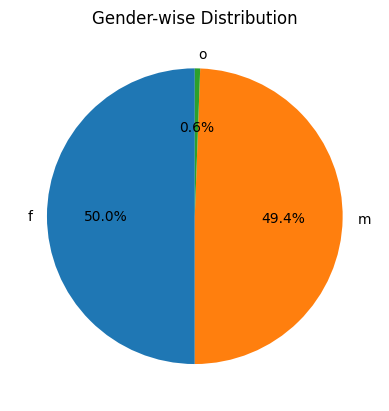

In [237]:
Gender_counts = df3['Gender'].value_counts()
print(Gender_counts)
print("Sample Size: ",len(df3['Gender'].dropna()))
#------------------------------------------------------
Gender_counts.plot.pie(autopct='%1.1f%%', startangle=90)
plt.ylabel('')  # Hide the y-label
plt.title('Gender-wise Distribution')
plt.show()

In [238]:
print(df3['Family_income'].unique())
print(df3['Family_income'].value_counts())

['below 3 lakhs' '10 - 12 lakhs' '7 - 10 lakhs' '3 -  7  lakhs'
 '15 lakhs above' '12 - 15 lakhs']
Family_income
3 -  7  lakhs     65
7 - 10 lakhs      29
below 3 lakhs     28
10 - 12 lakhs     22
15 lakhs above    17
12 - 15 lakhs     11
Name: count, dtype: int64


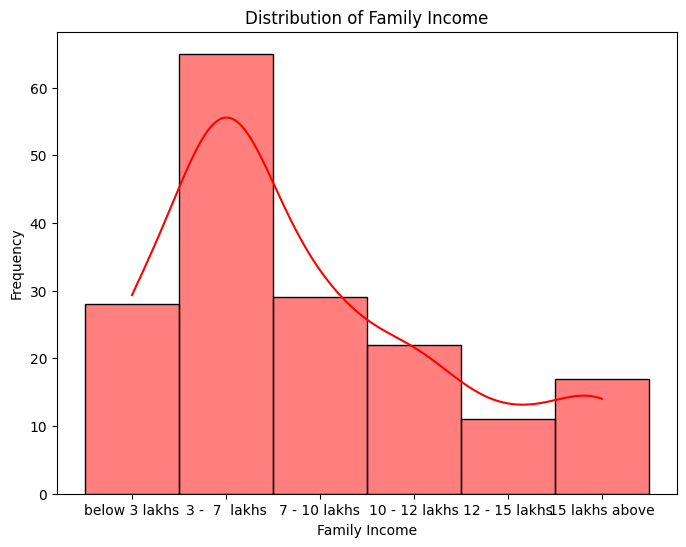

In [239]:
income_order = ['below 3 lakhs', '3 -  7  lakhs',  '7 - 10 lakhs', '10 - 12 lakhs', '12 - 15 lakhs', '15 lakhs above']

# Convert the column to a categorical type with the defined order
df3['family_income'] = pd.Categorical(df3['Family_income'], categories=income_order, ordered=True)


plt.figure(figsize=(8, 6))
sns.histplot(df3['family_income'], kde=True, bins=10, color='red')
plt.title('Distribution of Family Income')
plt.xlabel('Family Income')
plt.ylabel('Frequency')
plt.show()

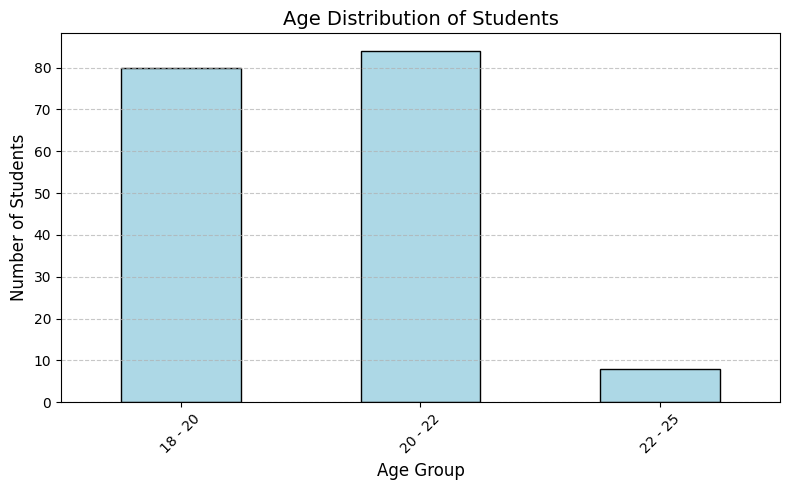

In [240]:
age_group_counts = df3['Age Group'].value_counts()

# Plot a bar diagram
plt.figure(figsize=(8, 5))
age_group_counts.sort_index().plot(kind='bar', color='lightblue', edgecolor='black')

# Add labels and title
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Number of Students', fontsize=12)
plt.title('Age Distribution of Students', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Show grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

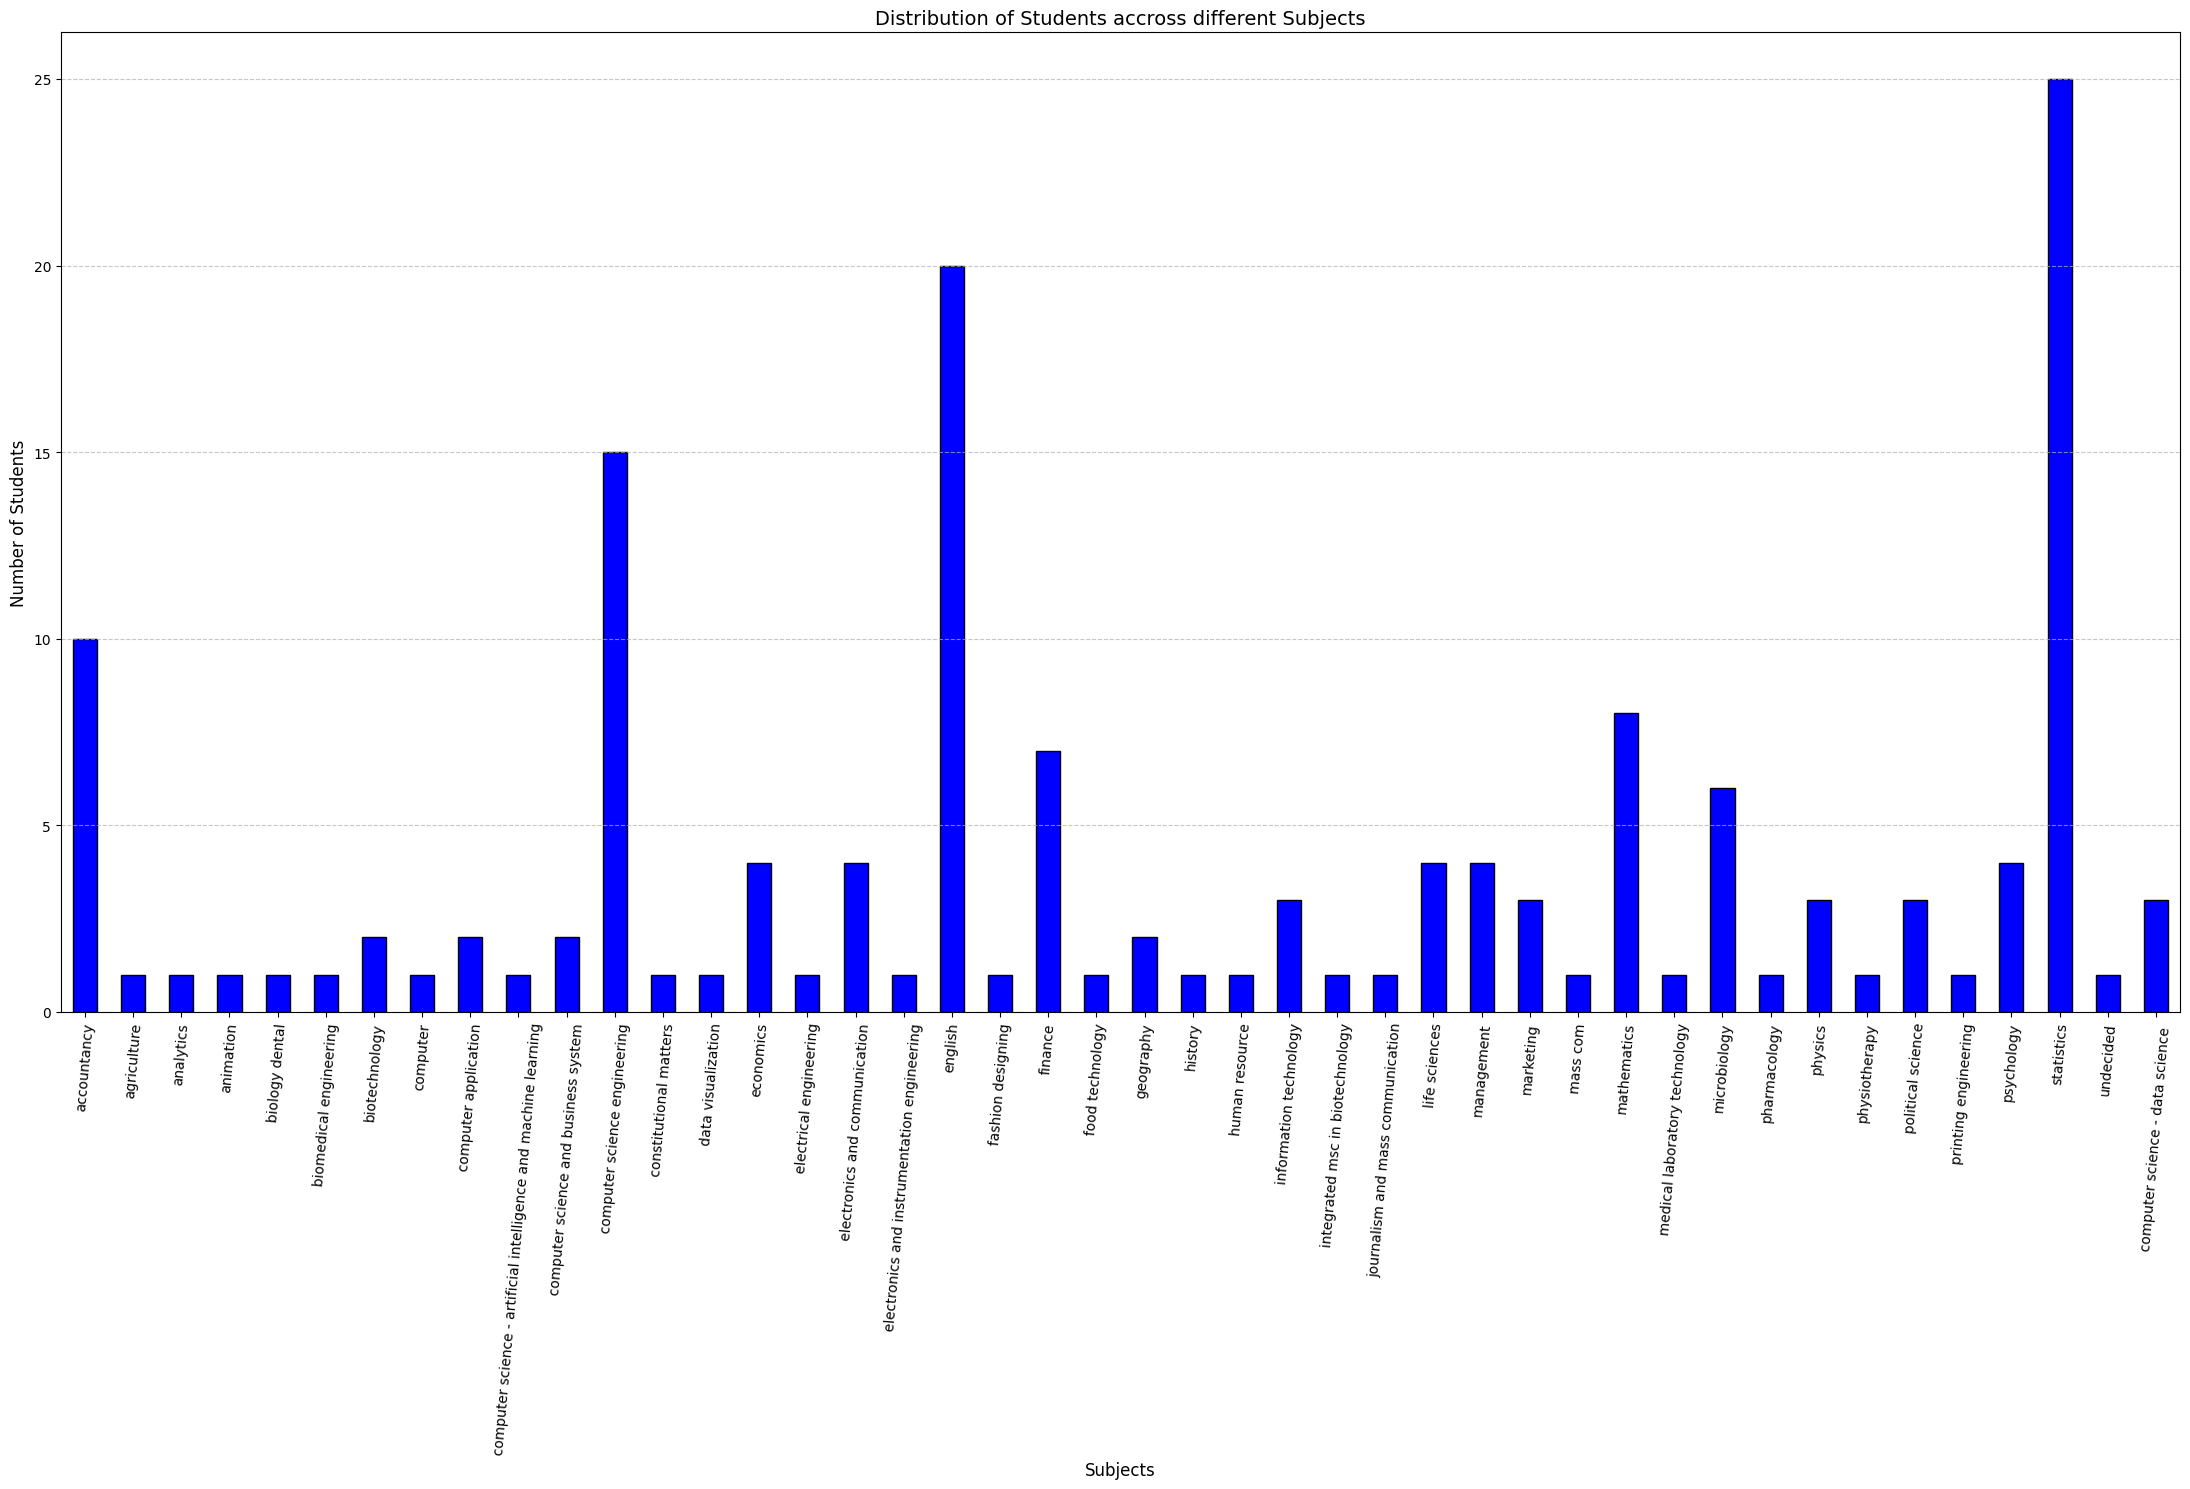

In [241]:
age_group_counts = df3['Subject'].value_counts()

# Plot a bar diagram
plt.figure(figsize=(22, 15))
age_group_counts.sort_index().plot(kind='bar', color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('Subjects', fontsize=12)
plt.ylabel('Number of Students', fontsize=12)
plt.title('Distribution of Students accross different Subjects', fontsize=14)
plt.xticks(rotation=85, fontsize=10)
plt.yticks(fontsize=10)

# Show grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

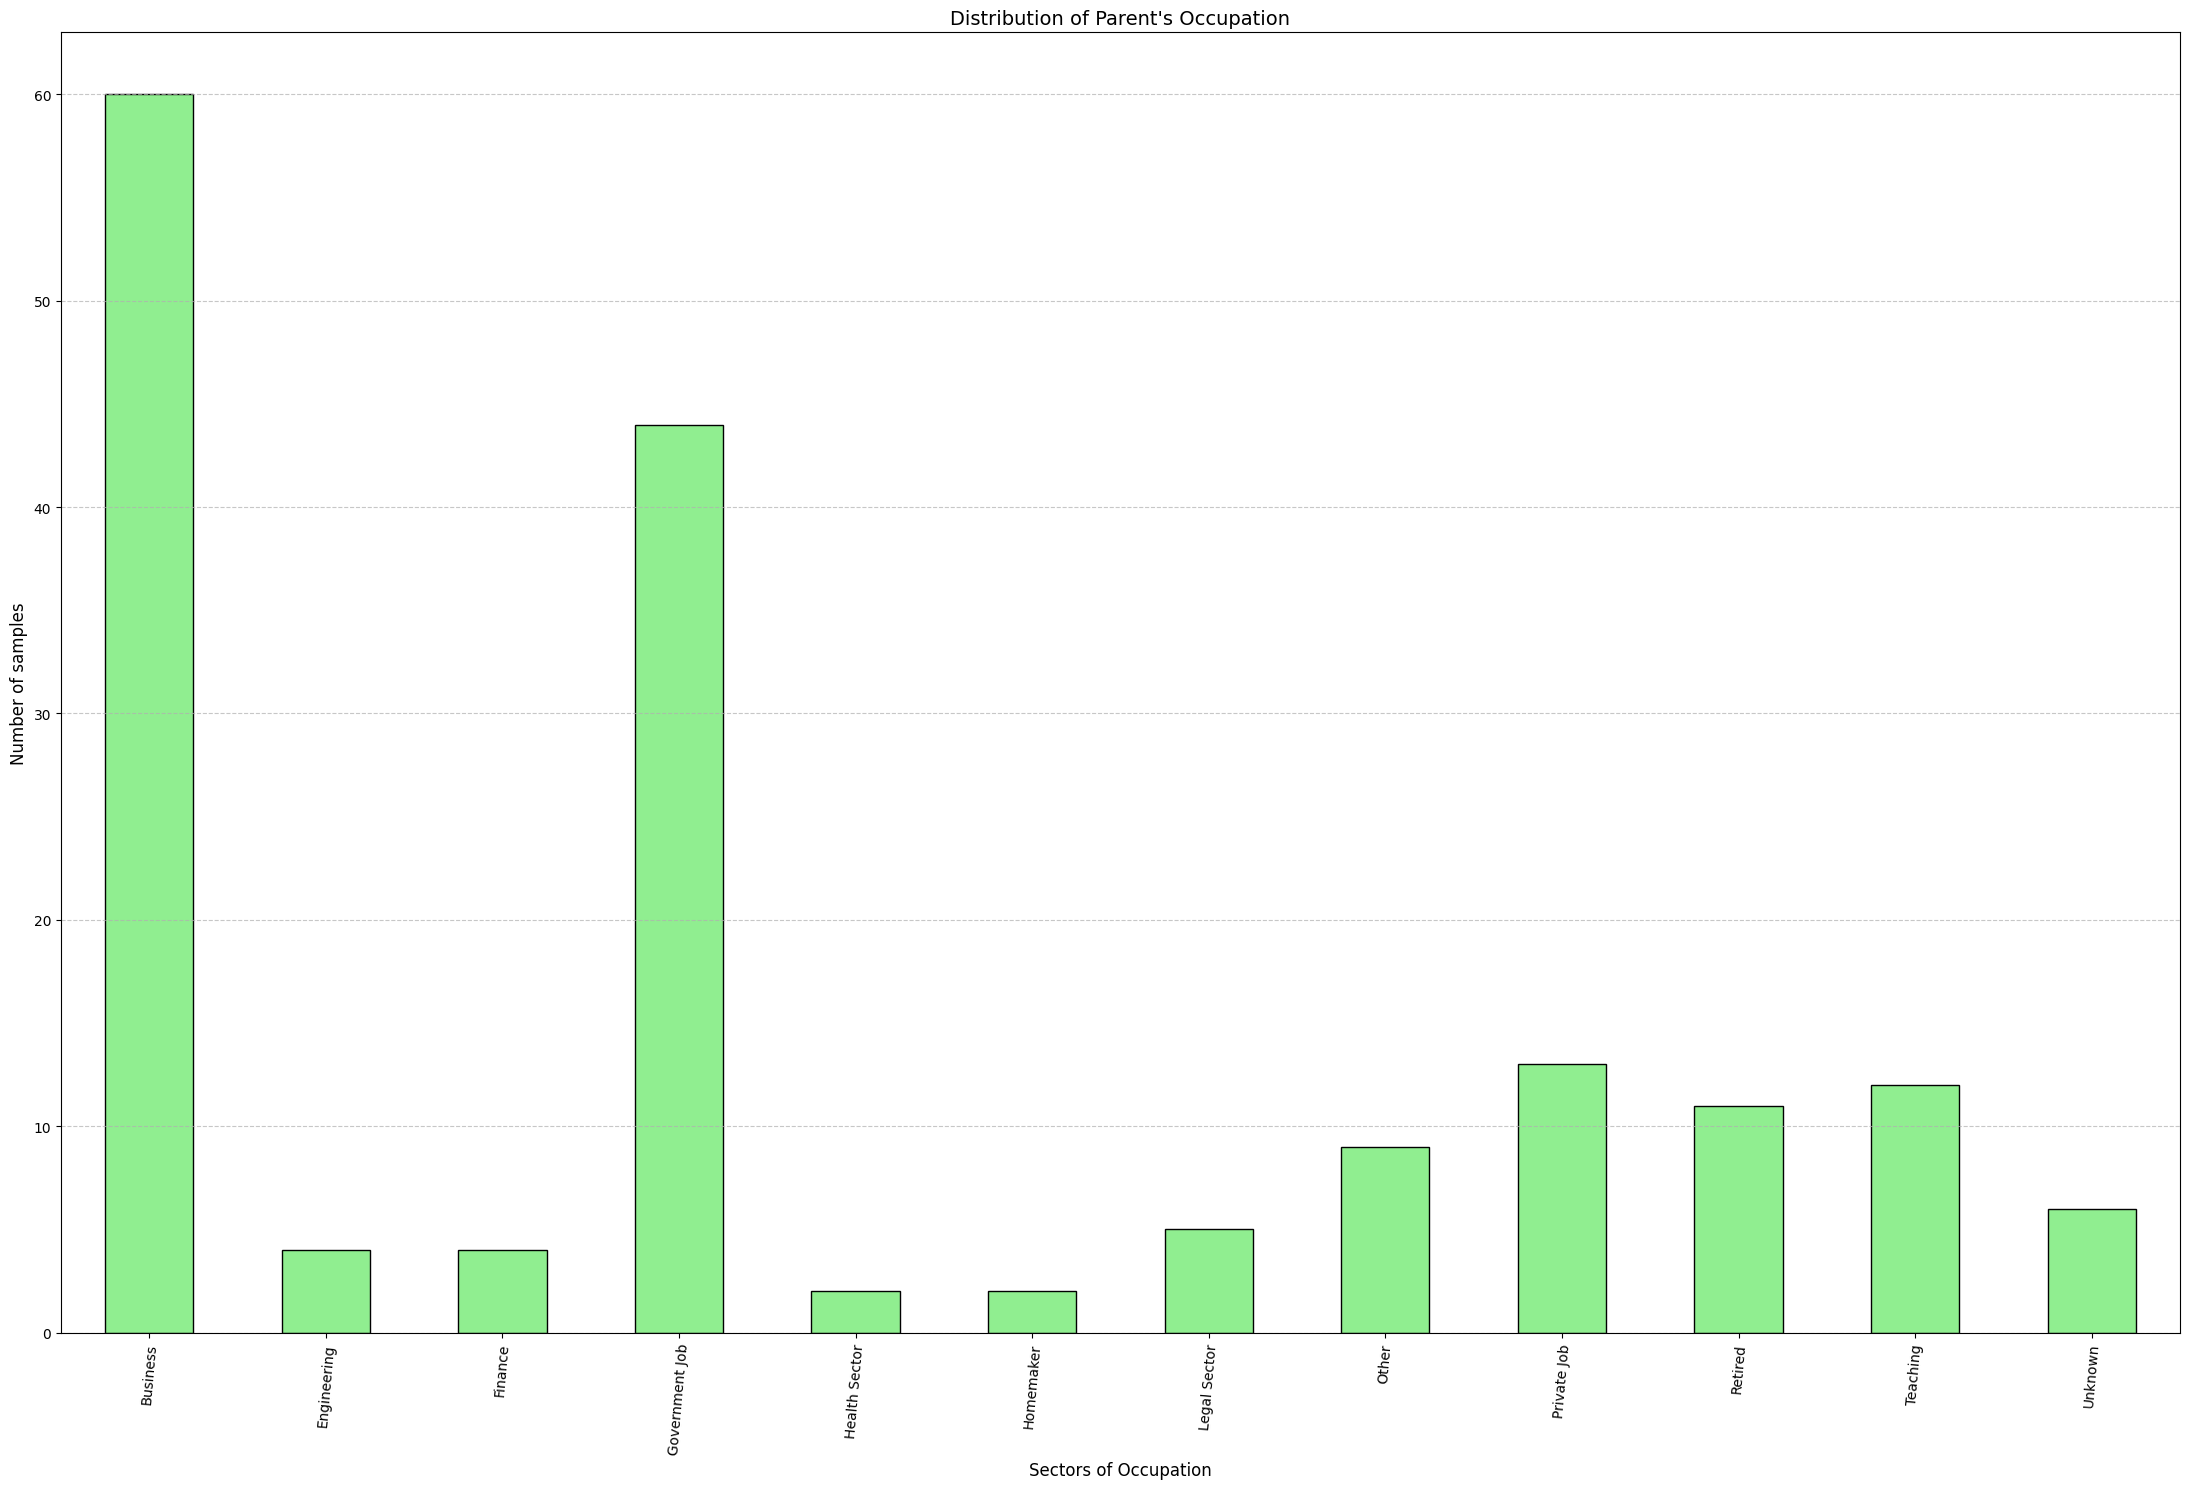

In [242]:
age_group_counts = df3["Parent's occupation"].value_counts()

# Plot a bar diagram
plt.figure(figsize=(22, 15))
age_group_counts.sort_index().plot(kind='bar', color='lightgreen', edgecolor='black')

# Add labels and title
plt.xlabel('Sectors of Occupation', fontsize=12)
plt.ylabel('Number of samples', fontsize=12)
plt.title("Distribution of Parent's Occupation", fontsize=14)
plt.xticks(rotation=85, fontsize=10)
plt.yticks(fontsize=10)

# Show grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

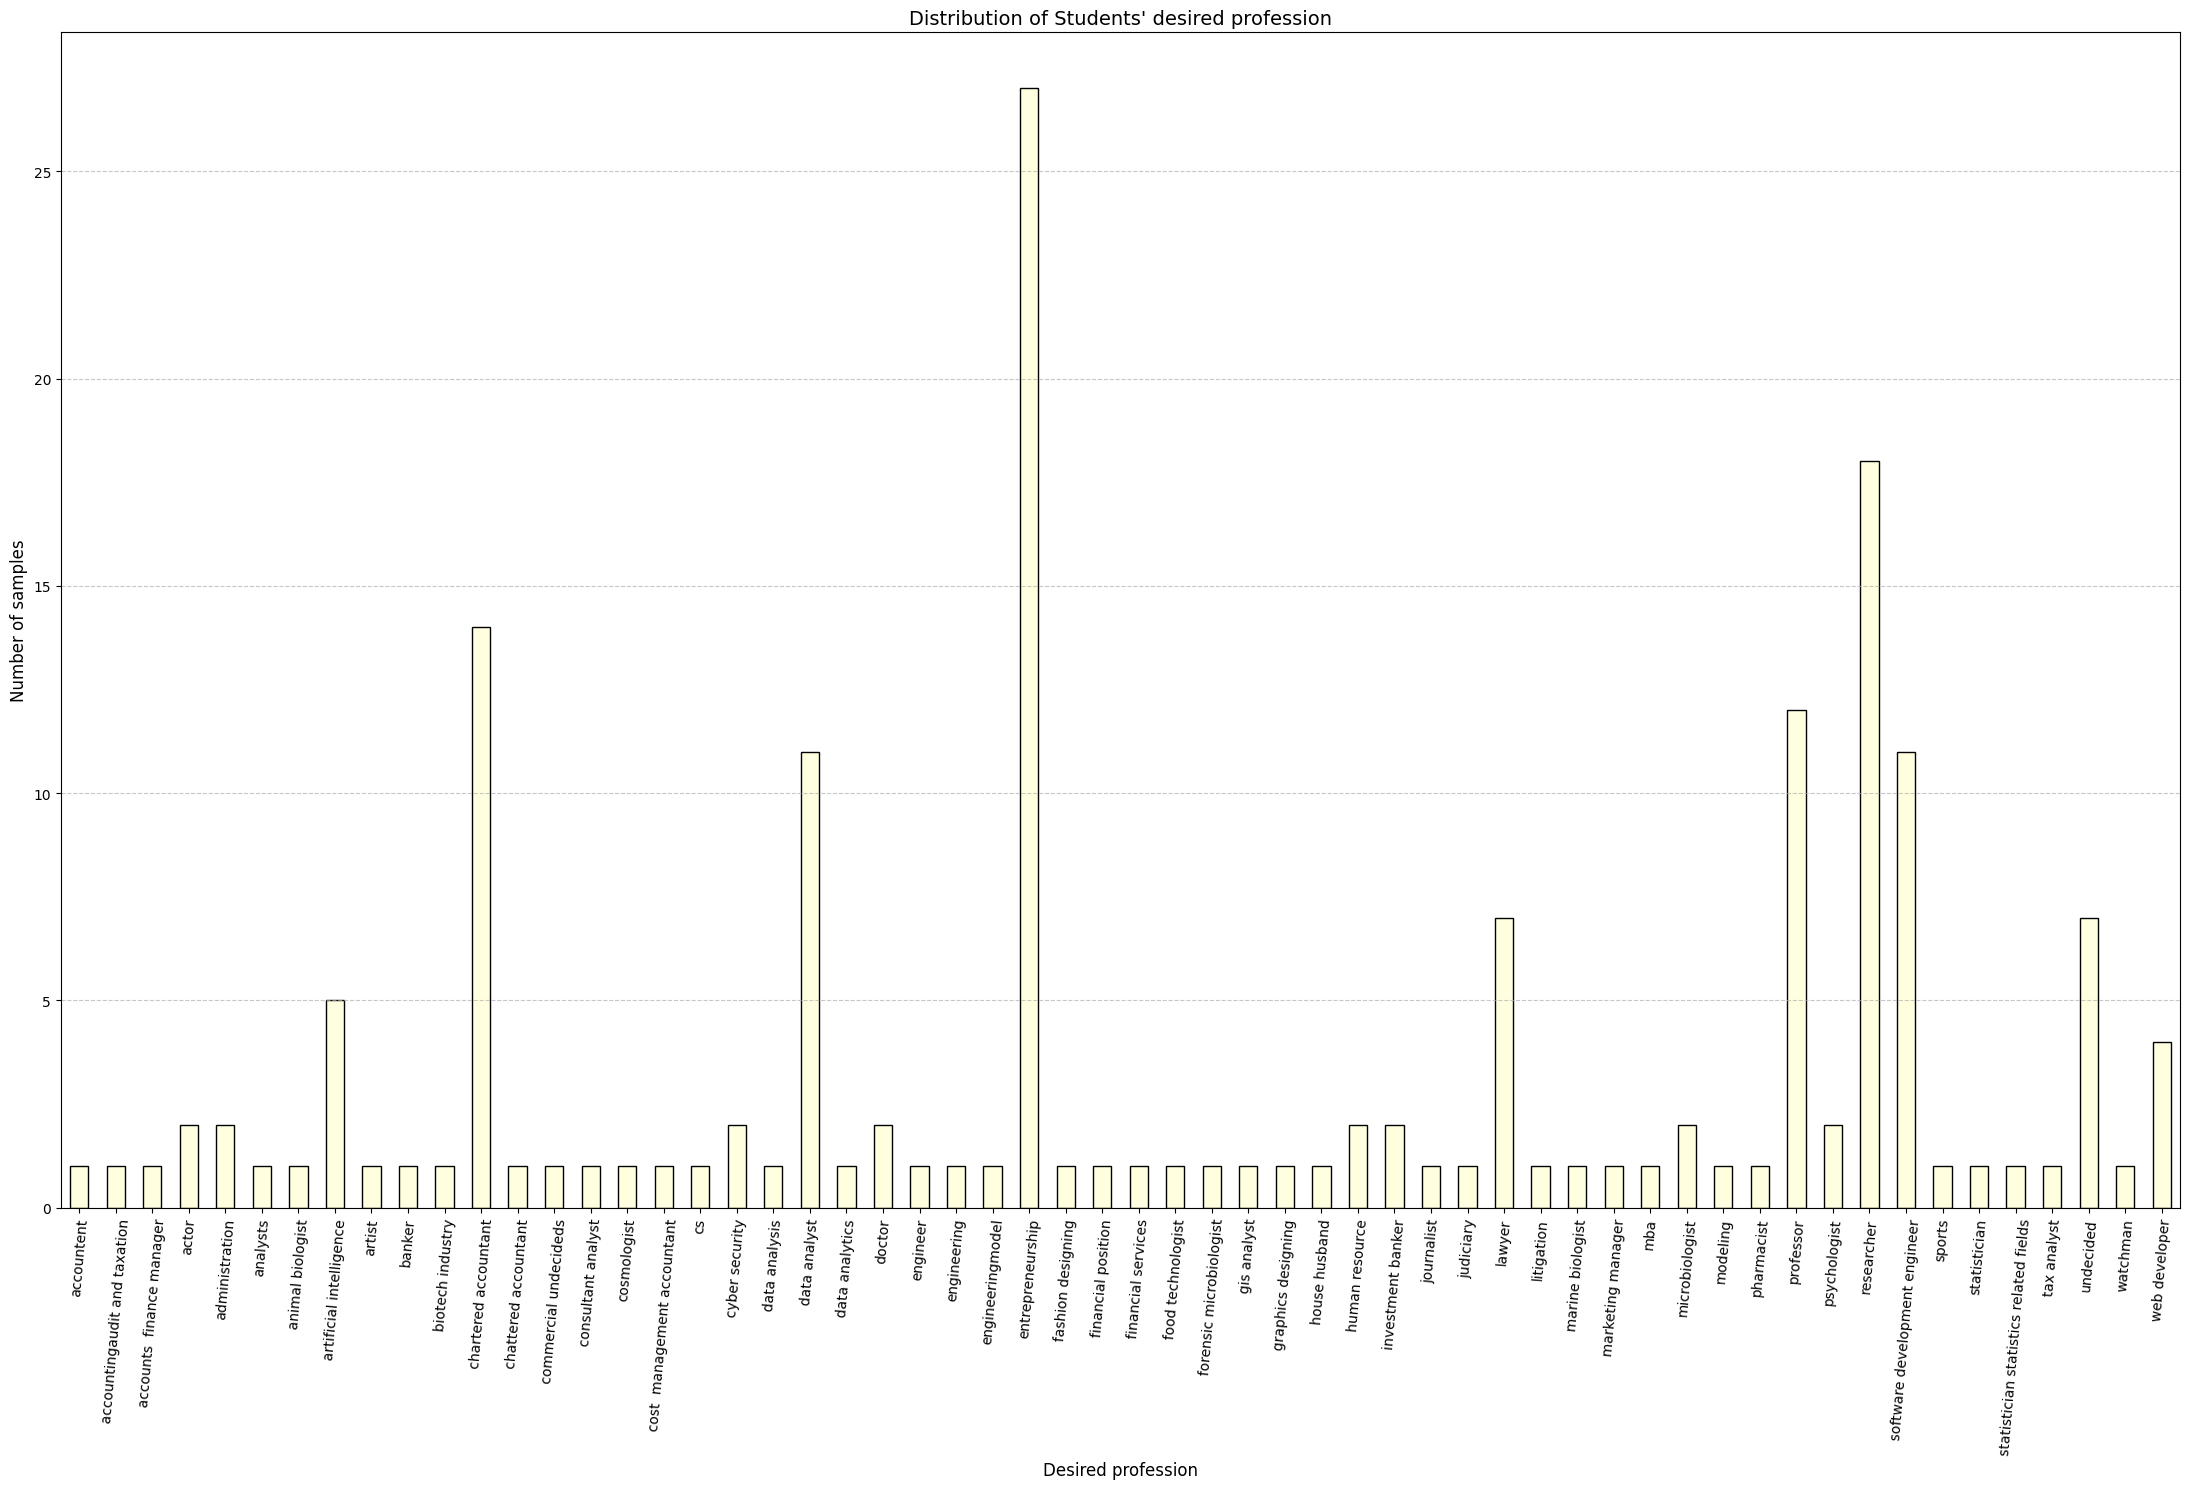

In [243]:
age_group_counts = df3["profession"].value_counts()

# Plot a bar diagram
plt.figure(figsize=(22, 15))
age_group_counts.sort_index().plot(kind='bar', color='lightyellow', edgecolor='black')

# Add labels and title
plt.xlabel('Desired profession', fontsize=12)
plt.ylabel('Number of samples', fontsize=12)
plt.title("Distribution of Students' desired profession", fontsize=14)
plt.xticks(rotation=85, fontsize=10)
plt.yticks(fontsize=10)

# Show grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()